# Synthesizer Forward Modelling

---

We have seen how to apply SED fitting to photometric observations to infer the physical properties of galaxies. The next step in most studies would be to then compare these quantities in a statistical sample to those from a simulation. However, the properties of simulated galaxies are known exactly, meaning that comparisons between the two could potentially be biased. One way to avoid this issue is to forward model simulations to produce direct observables such as photometry. This _synthetic_ observations can then be passed through the exact same pipelines as the real observations, such as Bagpipes, allowing for direct comparisons.

In this notebook, you will learn how to generate these observations using [Synthesizer](https://flaresimulations.github.io/synthesizer/)!

Synthesizer is modular, flexible and fast code for generating a range of synthetic observables. This can be done using either parametric models or particle data from simulations. You will use the later to generate synthetic observations of a galaxy from the TNG50 Simulation ([Nelson+18](https://arxiv.org/abs/1812.05609)) and then apply your knowledge of Bagpipes to measure the physical properties as you would a real galaxy.

---

In [2]:
# Importing the required modules.
import os.path
import pickle
import h5py
import requests

import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
from unyt import Gyr, Myr, kpc

from synthesizer.filters import FilterCollection, UVJ
from synthesizer.particle import Stars, Galaxy
from synthesizer.grid import Grid
from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.attenuation.igm import Inoue14

import bagpipes as pipes
# Change this to 'nautilus' if required.
sampler = 'multinest'    

In [3]:
#---------------------------------------------------------------------
api_key = "c37483fea84b70f4ad9f777c38357ea0"    # Your TNG-API key.
data_path = '../data'    # Directory in which to store simulation data.
#---------------------------------------------------------------------

headers = {"api-key":api_key}

Lets start by displaying the properties of TNG50, including the box size, mass resolution and the physics implemented. Familiarise yourself with the simulation. It is the highest resolution of all the TNG boxes, so should contain some nice galaxies!

We can use this data to define the cosmology and redshift snapshot information that we will use later.

In [4]:
# Function for fetching simulation data from the TNG API.
def get(path, data_path, headers, params=None):

    # Make HTTP GET request to path.
    r = requests.get(path, params=params, headers=headers)

    # Raise exception if response code is not HTTP SUCCESS (200).
    r.raise_for_status()

    # Parse json responses automatically.
    if r.headers['content-type'] == 'application/json':
        return r.json() 

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(f'{data_path}/'+filename, 'wb') as f:
            f.write(r.content)
        return filename

    return r

In [5]:
# URL of the chosen simulation.
baseUrl = 'http://www.tng-project.org/api/TNG50-1/'

# Query for simulation properties.
sim = get(baseUrl, data_path, headers=headers)
for k, v in sim.items():
    print(f'{k}: {v}')

name: TNG50-1
description: Main high-resolution IllustrisTNG50 run including the full TNG physics model.
name_alt: L35n2160TNG
boxsize: 35000.0
z_start: 127.0
z_final: 0.0
cosmology: Planck2015
omega_0: 0.3089
omega_L: 0.6911
omega_B: 0.0486
hubble: 0.6774
physics_model: Fiducial TNG Model
has_cooling: True
has_starformation: True
has_winds: True
has_blackholes: True
mass_gas: 5.73879e-06
mass_dm: 3.07367708626464e-05
softening_dm_comoving: 0.39
softening_stars_comoving: 0.39
softening_blackholes_comoving: 0.39
softening_gas_comoving: 0.39
softening_dm_max_phys: 0.195
softening_stars_max_phys: 0.195
softening_blackholes_max_phys: 0.39
softening_gas_max_phys: 0.195
softening_gas_factor: 2.5
softening_gas_comoving_min: 0.05
num_dm: 10077696000
num_tr_mc: 10077696000
num_tr_vel: 0
longids: True
is_uniform: True
is_zoom: False
is_subbox: False
num_files_snapshot: 680
num_files_groupcat: 680
num_files_rockstar: 0
num_files_lhalotree: 200
num_files_sublink: 11
num_files_ctrees: 0
filesize_lh

In [6]:
# Define a LambdaCDM cosmology using parameters from the simulation.
Om0 = sim['omega_0']
Ob0 = sim['omega_B']
Ode0 = sim['omega_L']
h = sim['hubble']
H0 = h * 100 

cosmo = LambdaCDM(Om0=Om0, Ode0=Ode0, H0=H0, Ob0=Ob0)

# Create a dictionary of snapshots and redshifts.
snapshots = get(sim['snapshots'], data_path, headers)
snapshot_redshifts = {snapshot['number']: snapshot['redshift'] for snapshot in snapshots}

Now lets choose which galaxy to extract from the simulation by selecting an ID. You can choose this at random, but the default value is good if you want nice spiral arms. After choosing the redshift snapshot at which to observe the galaxy, we can fetch and display its properties such as mass, metallicity and star formation rate. 

If you change the redshift but not the ID, you will need to delete the previous files as they will not be overwritten. It is also important to note that IDs are not consistent across snapshots. So $\textrm{ID} = 1$ at $z = 5$ may not be the same object as $\textrm{ID} = 1$ at $z = 0$.

In [7]:
#---------------------------------------------------------
id = '145492'    # The ID of the galaxy you wish to image.
redshift = 2    # The redshift snapshot to use.
#---------------------------------------------------------

# The data url for the object of interest.
url = f"{baseUrl}/snapshots/z={str(redshift)}/subhalos/{str(id)}"

In [8]:
# We will need the coordinates, metallicity, age, and initial mass of
# all the star particles.
params = {'stars':'Coordinates,GFM_Metallicity,GFM_StellarFormationTime,GFM_InitialMass'}

# Download the subhalo properties and save them as a pickle file.
subhalo_properties_filename = f'{data_path}/subhalo_properties_{id}.pkl'
if not os.path.isfile(subhalo_properties_filename):
    subhalo_properties = get(url, data_path, headers)
    pickle.dump(subhalo_properties, open(subhalo_properties_filename,'wb'))

# Download the HDF5 cutout for the galaxy.
cutout_filename = f'{data_path}/cutout_{id}.hdf5'
if not os.path.isfile(cutout_filename):
    get(url + "/cutout.hdf5", data_path, headers, params)

In [9]:
# Display the galaxy properties,
subhalo_properties = pickle.load(open(f'{data_path}/subhalo_properties_{id}.pkl','rb'))
for k,v in subhalo_properties.items():
    print(f'{k}: {v}')

# and the exact snapshot redshift.
snapshot_redshift = snapshot_redshifts[subhalo_properties['snap']]
print(f'snapshot redshift: {snapshot_redshift}')

snap: 33
id: 145492
bhmdot: 0.00214158
cm_x: 2631.63
cm_y: 22423.6
cm_z: 32813.0
gasmetallicity: 0.0234775
gasmetallicityhalfrad: 0.0332981
gasmetallicitymaxrad: 0.0139534
gasmetallicitysfr: 0.0156152
gasmetallicitysfrweighted: 0.0216725
pos_x: 2614.18
pos_y: 22429.6
pos_z: 32811.7
halfmassrad: 71.0307
halfmassrad_gas: 67.2129
halfmassrad_dm: 75.0715
halfmassrad_stars: 7.5072
halfmassrad_bhs: 0.0
len: 2303786
len_gas: 793943
len_dm: 1201183
len_stars: 308659
len_bhs: 1
mass: 43.4305
mass_gas: 5.0807
mass_dm: 36.9205
mass_stars: 1.42703
mass_bhs: 0.002327
massinhalfrad: 2.0413
massinhalfrad_gas: 0.196656
massinhalfrad_dm: 1.12881
massinhalfrad_stars: 0.713511
massinhalfrad_bhs: 0.002327
massinmaxrad: 12.493
massinmaxrad_gas: 1.64067
massinmaxrad_dm: 9.48976
massinmaxrad_stars: 1.36023
massinmaxrad_bhs: 0.002327
massinrad: 4.61426
massinrad_gas: 0.622574
massinrad_dm: 2.90797
massinrad_stars: 1.08139
massinrad_bhs: 0.002327
sfr: 15.455
sfrinhalfrad: 4.07666
sfrinmaxrad: 15.043
sfrinrad: 

Now we can start using Synthesizer! After processing the star particle (PartType4) properties, we can use these to initialise a `Stars` object. This is described by age, mass and metallicity and can then be used to create a synthetic `Galaxy` at the snapshot redshift. Try not to confuse this with the Bagpipes `galaxy`.

If you get an error at this point, it is likely because you have selected an object without stars.

In [10]:
# Open the cutout file containing the stellar properties.
with h5py.File(cutout_filename) as f:

    # Use the scale factor at time of formation to get formation
    # redshift.  
    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    # Only want stars that formed before the current snapshot.
    s = formation_redshift >= snapshot_redshift
    formation_redshift = formation_redshift[s]

    # Calculate their ages in Myr.
    ages = (cosmo.age(z=snapshot_redshift)-cosmo.age(formation_redshift)).to('Myr').value * Myr

    # Convert intital mass to solar mass units.
    initial_masses = f['PartType4']['GFM_InitialMass'][s] * 1E10 / h

    # Extract the metallicities.
    metallicities = f['PartType4']['GFM_Metallicity'][s]

    # Define the locations of the stars, 
    x = f['PartType4']['Coordinates'][s,0] 
    y = f['PartType4']['Coordinates'][s,1] 
    z = f['PartType4']['Coordinates'][s,2] 

    # and convert to physical units.
    coordinates = np.array([x,y,z]).T / (1+snapshot_redshift) / h / 1000

In [11]:
# Create a Stars object by defining each star's age, mass, metallicity 
# and position.

# Define the centre of the galaxy.
centre = np.array([subhalo_properties['pos_x'],
                   subhalo_properties['pos_y'],
                   subhalo_properties['pos_z'],
                   ])

stars = Stars(
    ages=ages,
    initial_masses=initial_masses,
    metallicities=metallicities,
    coordinates=coordinates,
    centre = centre
    )

# Initialise the galaxy object at this position and the
# snapshot redshift.
galaxy = Galaxy(stars=stars, centre=centre, redshift=snapshot_redshift)

/Users/jt458/synth_sed/ACES/lib/python3.10/site-packages/synthesizer/particle/galaxy.py:114: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()


Before we can start using the `Galaxy` object we need to define an `EmissionModel` which translates the properties of the stellar population to a spectral energy distribution. These models can become quite complex and describe the escape fraction, dust attenuation and dust emission of a galaxy. For now, we will use a simple `PacmanEmission` model, with dust attenuation characterised by a `PowerLaw` screen. 

We also need to define a Stellar Population Synthesis (SPS) `Grid` which describes stellar spectra as a function of age and metallicity. We will use the test grid, which you should have downloaded earlier.

In [12]:
#------------------------------------------
tau_v = 0.5    # Dust V-band optical depth.
alpha = -1.0    # Dust curve slope.
grid_dir = '../grids'    # Grid directory.
grid_name = 'test_grid'    # Grid name.
#------------------------------------------

# Define a power-law dust curve.
dust_curve = PowerLaw(slope=alpha)

# Load the age-metallicity grid and interpolate onto a low resolution 
# wavelength grid.
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

# Define the screen emission model.
screen = PacmanEmission(
    grid=grid,
    tau_v=tau_v,
    dust_curve=dust_curve
    )

Lets have a look at the SED of our galaxy. We can do this by applying the screen `EmissionModel` to the stars using the `get_spectra` method. Plotting the SED, we can see how each individual element contributes to the final spectrum. To see how each element is related, we can use the `plot_emission_tree` method of our `EmissionModel`. At the top of the tree, "Emergent" is the final combined spectrum. This may not always be the case if you include additional components.

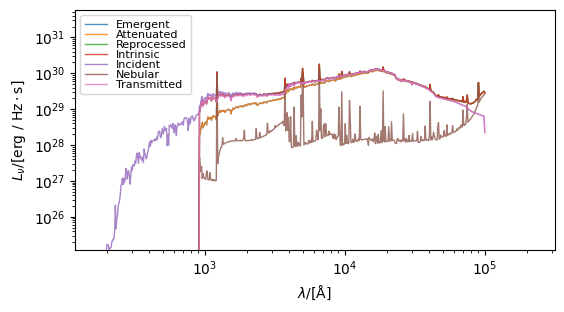

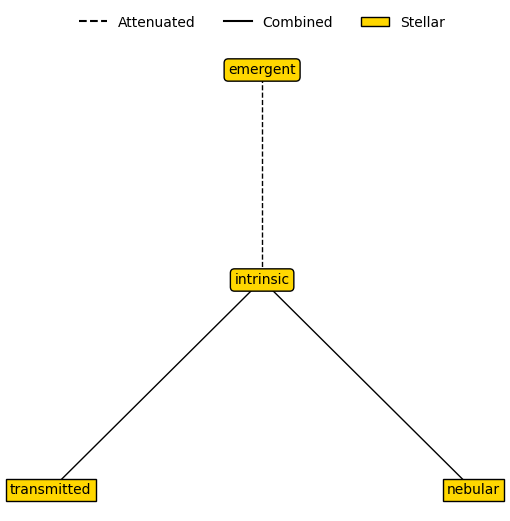

In [13]:
# Generate each of the available spectra.
spectra = galaxy.stars.get_spectra(screen)

# Display the SED,
fig, ax = galaxy.stars.plot_spectra(show=True, figsize=(6, 4))

# and the emission model tree.
fig, ax = screen.plot_emission_tree()

Now we can create an image of our galaxy. We will need the spectra of each individual stellar particle and from that we can extract the flux in specific wavelength filters, defined as a `FilterCollection`. Here we use the built in `UVJ` set, but Synthesizer can automatically pull transmission curves from the SVO Filter Profile Service. After calculating the particle luminosities, we can generate images in each filter, or create an RGB image!

In [14]:
# We only want the "emergent" photometry.
screen.set_save(False, set_all=True)
screen["emergent"].set_save(True)

# Get the spectrum of each star particle.
galaxy.stars.get_particle_spectra(screen)

# Define the UVJ filter collection.
filters = UVJ(new_lam=grid.lam)

# Measure the photometric luminosities.
galaxy.stars.get_particle_photo_lnu(filters)

{'emergent': <synthesizer.photometry.PhotometryCollection at 0x36f812230>}

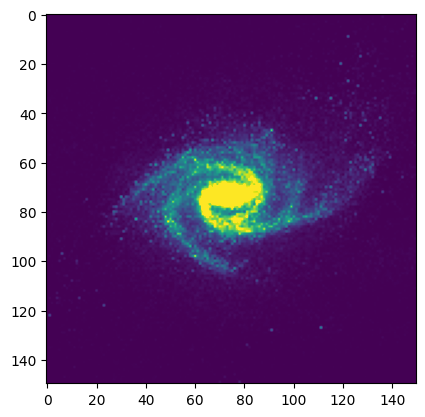

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..23.70166237856547].


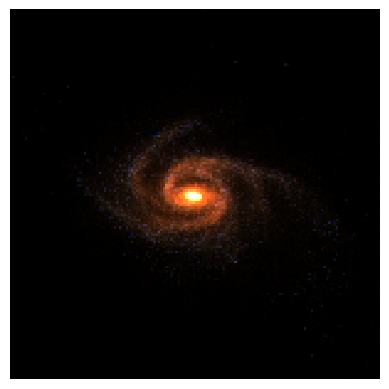

In [15]:
#------------------------------------------
fov = 40 * kpc    # The image FOV.
npix = 150    # Number of pixels on a side.
#------------------------------------------

# Calculate the resolution.
resolution = fov / npix

# Generate luminosity images.
img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="emergent",
    fov=fov,
)

# Show the V-band image,
vmin = np.percentile(img.imgs['V'].arr, 1)  
vmax = np.percentile(img.imgs['V'].arr, 99)  
ax = plt.imshow(img.imgs['V'].arr, vmin = vmin, vmax = vmax)
plt.show()

# and an RGB.
img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
# You may need to play with `vmax` if you changed anything above.
fig, ax, _ = img.plot_rgb_image(show=True, vmin=0., vmax=1E27)
plt.show()

__Task__: Generate the observed photometry of your Synthesizer galaxy in any filters of your choosing. Add errors and noise based on a reasonable percentage error.

__Task:__ Determine which of Bagpipes' SFH parameterisations best matches that of your chosen galaxy. You can easily plot the SFH of your galaxy using Synthesizer.

__Task__: Use Bagpipes to fit the noisy photometry. Use the SFH you determined above, fix the redshift at the true value and choose the other model components appropriately. How well are the true values recovered?

You can fix $\mathrm{logU} = -2$, which is the value used to generate Synthesizer grids.

__Extension__: Forward model your own simulation.

If you still have the results of your SWIFT simulation, why not try forward modelling your hydrodynamics run?

You've now completed the full forward modelling pipeline by generating photometry and applying observational techniques. Can you trust the results of these techniques? Find out in the next notebook.